<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex08/leonardo_lellis/Aula_8_Exerc%C3%ADcio_Leonardo_de_Lellis_Rossi_RA261900.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
nome = "Leonardo de Lellis Rossi RA261900"
print(f'Meu nome é {nome}')

Meu nome é Leonardo de Lellis Rossi RA261900


#  Exercício: Modelo de Linguagem com auto-atenção

Este exercício é similar ao da Aula 7, mas iremos agora treinar uma rede neural *com auto-atenção* para prever a próxima palavra de um texto, data as palavras anteriores como entrada. 

Na camada de auto-atenção, não se esqueça de implementar:
- Embeddings de posição
- Projeções lineares (WQ, WK, WV, WO)
- Conexões residuais
- Camada de feed forward (2-layer MLP)



O dataset usado neste exercício (BrWaC) possui um tamanho razoável e você vai precisar rodar seus experimentos com GPU.

Alguns conselhos úteis:
- **ATENÇÃO:** o dataset é bem grande. Não dê comando de imprimí-lo.
- Durante a depuração, faça seu dataset ficar bem pequeno, para que a depuração seja mais rápida e não precise de GPU. Somente ligue a GPU quando o seu laço de treinamento já está funcionando
- Não deixe para fazer esse exercício na véspera. Ele é trabalhoso.

In [2]:
# iremos utilizar a biblioteca dos transformers para ter acesso ao tokenizador do BERT.
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importação dos pacotes

In [3]:
import collections
import itertools
import functools
import math
import random

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook


In [4]:
debug = False
checkinpoint = True
save_in_drive = True

params = {
    'max_examples': 100_000_000,
    'eval_every_steps': 10000,
    'lr': 3e-4,
    'batch_size': 256,
    'embedding_dim': 128,
    'hidden_size': 2*128,
    'optimizer': 'Adam',
    'paper': 'https://arxiv.org/abs/1706.03762',
    'retrain': False,
    'path_saved_model': 'gdrive/MyDrive/Colab Notebooks/best_model_Aula8_bs256_emb128.pt'
}

In [5]:
# Check which GPU we are using
!nvidia-smi

Wed May 25 14:46:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


In [7]:
 !pip install -U neptune-client
 import neptune.new as neptune

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
run = neptune.init(name= 'Ex. Aula 8', tags=['Aula 8', 'Auto--atenção', 'Self-Attention', 'Vaswani2017', 'checkinpoint', 'CrossEntropy', 'Adam', 'perplexity', 'BrWaC'],
    project="leolellisr/dl-ia025",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1NjY1YmJkZi1hYmM5LTQ3M2QtOGU1ZC1iZTFlNWY4NjE1NDQifQ==",
)

https://app.neptune.ai/leolellisr/dl-ia025/e/DLIA-88
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [9]:
def set_seeds():
  random.seed(123)
  np.random.seed(123)
  torch.manual_seed(123)
  torch.cuda.manual_seed(123)
set_seeds()

## Implementação do MyDataset

In [10]:
from typing import List


def tokenize(text: str, tokenizer):
    return tokenizer(text, return_tensors=None, add_special_tokens=False).input_ids


class MyDataset():
    def __init__(self, texts: List[str], tokenizer, context_size: int):
        #self.examples = []
        self.X = []
        self.y = []
        for text in tqdm_notebook(texts):
            token_ids = tokenize(text=text, tokenizer=tokenizer)
            if len(token_ids) < context_size + 1:
                continue
            # Compute n-grams:
            for i in range(len(token_ids) - context_size):
                 
                #self.examples.append((input_ids, target_id)) 
                self.X.append(token_ids[i:i + context_size])      
                self.y.append(token_ids[i + context_size])
             

    def __len__(self):
        # Escreva seu código aqui
        return len(self.X)

    def __getitem__(self, idx):
        # Escreva seu código aqui
        return torch.tensor(self.X[idx]).long(), torch.tensor(self.y[idx]).long()        

## Testando se a implementação do MyDataset está correta

In [11]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")

dummy_texts = ['Eu gosto de correr', 'Ela gosta muito de comer pizza']

dummy_dataset = MyDataset(texts=dummy_texts, tokenizer=tokenizer, context_size=3)
dummy_loader = DataLoader(dummy_dataset, batch_size=6, shuffle=False)
assert len(dummy_dataset) == 5
print('passou no assert de tamanho do dataset')

first_batch_input, first_batch_target = next(iter(dummy_loader))

correct_first_batch_input = torch.LongTensor(
    [[ 3396, 10303,   125],
     [ 1660,  5971,   785],
     [ 5971,   785,   125],
     [  785,   125,  1847],
     [  125,  1847, 13779]])

correct_first_batch_target = torch.LongTensor([13239,   125,  1847, 13779, 15616])

assert torch.equal(first_batch_input, correct_first_batch_input)
print('Passou no assert de input')
assert torch.equal(first_batch_target, correct_first_batch_target)
print('Passou no assert de target')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/2 [00:00<?, ?it/s]

passou no assert de tamanho do dataset
Passou no assert de input
Passou no assert de target


In [12]:
from google.colab import drive

if save_in_drive: drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Carregamento do dataset 

Iremos usar uma pequena amostra do dataset [BrWaC](https://www.inf.ufrgs.br/pln/wiki/index.php?title=BrWaC) para treinar e avaliar nosso modelo de linguagem.

In [13]:
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula7/sample_brwac.txt

File ‘sample_brwac.txt’ already there; not retrieving.



In [14]:
# Load datasets
context_size = 9

valid_examples = 100
test_examples = 100
texts = open('sample_brwac.txt').readlines()

if debug:
  print('Truncating for debugging purposes.')
  texts = texts[:500]  

training_texts = texts[:-(valid_examples + test_examples)]
valid_texts = texts[-(valid_examples + test_examples):-test_examples]
test_texts = texts[-test_examples:]

training_dataset = MyDataset(texts=training_texts, tokenizer=tokenizer, context_size=context_size)
valid_dataset = MyDataset(texts=valid_texts, tokenizer=tokenizer, context_size=context_size)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/24800 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
print(f'training examples: {len(training_dataset)}')
print(f'valid examples: {len(valid_dataset)}')



training examples: 27675945
valid examples: 82070


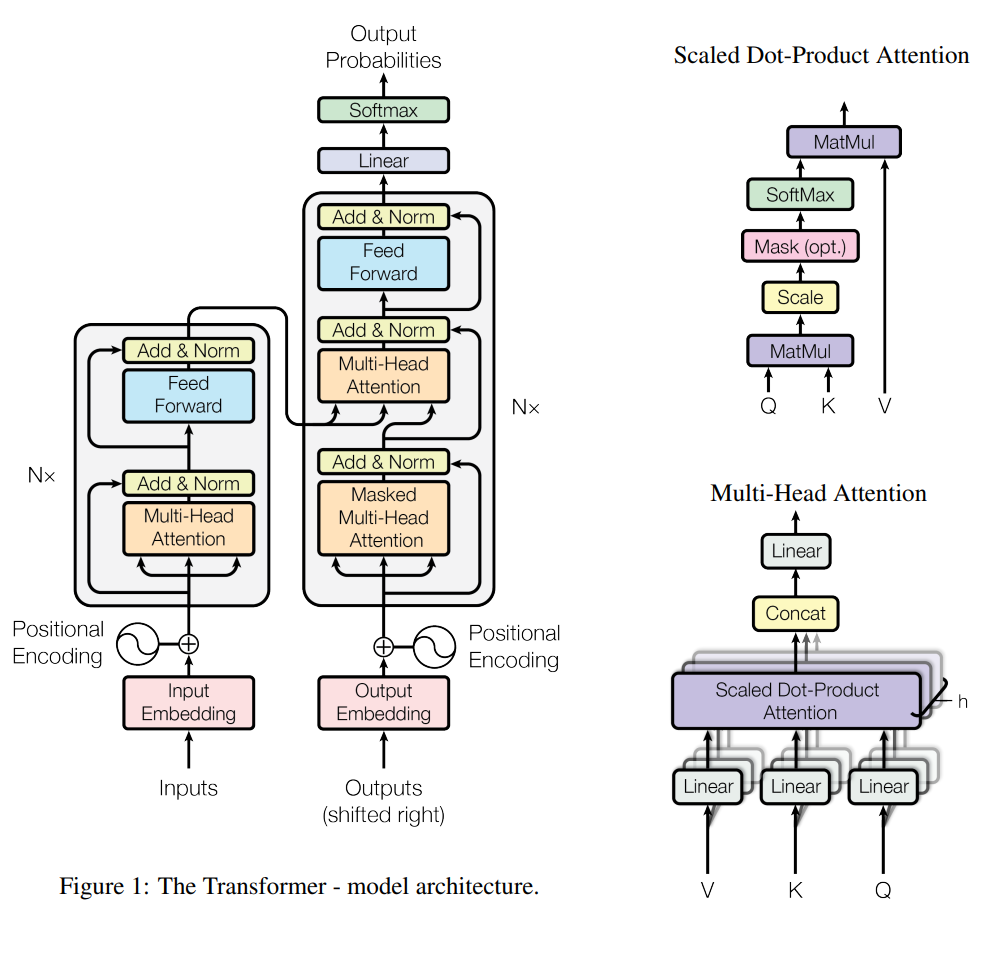

In [16]:
from IPython import display
display.Image("https://i.imgur.com/4pGKOAD.png")

In [17]:
import torch.nn.functional as F

class LanguageModel(torch.nn.Module):

    def __init__(self, vocab_size, context_size, embedding_dim, hidden_size):
        """
        Implements the Self-attention, decoder-only."

        Args:
            vocab_size (int): Size of the input vocabulary.
            context_size (int): Size of the sequence to consider as context for prediction.
            embedding_dim (int): Dimension of the embedding layer for each word in the context.
        """
        # Escreva seu código aqui.

        super().__init__()
        
        self.context_size = context_size
        self.embedding_dim = embedding_dim

        # word embedding 
        self.embeddings_c = nn.Embedding(vocab_size, embedding_dim)

        # Embedding of the words positions
        self.embeddings_p = nn.Embedding(context_size, embedding_dim) 

        self.W_q = nn.Linear(embedding_dim, embedding_dim, bias=False) 
        self.W_k = nn.Linear(embedding_dim, embedding_dim, bias=False) 
        self.W_v = nn.Linear(embedding_dim, embedding_dim, bias=False) 
        self.W_o = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.hidden_size = hidden_size
        self.linear_layer1 = nn.Linear(self.embedding_dim, self.hidden_size)
        self.linear_layer2 = nn.Linear(self.hidden_size,vocab_size, bias = False)
        self.relu = torch.nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, inputs):
        """
        Args:
            inputs is a LongTensor of shape (batch_size, context_size)
            B: batch_size
            L: context_size
            D: embedding_dim
            V: vocab_size
            input shape: (B, L)
            pos shape: (B, L)
        Returns:
            logits of shape (batch_size, vocab_size)
        """
        # Escreva seu código aqui.
        batch_size = inputs.shape[0]

        # input shape: (B, L)
        inputs_pos = torch.arange(0, self.context_size).unsqueeze(0).repeat(batch_size,1).to(inputs.device)
        out = self.embeddings_c(inputs) + self.embeddings_p(inputs_pos)
                
        # q = out*W_q
        out_1 = out[:,-1,:].unsqueeze(1) # (B, D)
        q = self.W_q(out_1).to(device) # (B,L,D)
        if debug: print(f"q (B,L,D): {q.shape}")

        # k = out* W_k
        k = self.W_k(out).to(device) # (B,L,D)
        if debug: print(f"k (B,L,D): {k.shape}")

        # v = out*W_v
        v = self.W_v(out).to(device) # (B,L,D)
        if debug: print(f"v (B,L,D): {v.shape}")

        # s = q*k.T
        # s = s/sqrt(D)
        scores = torch.matmul(q, torch.transpose(k,1,2))/math.sqrt(self.embedding_dim) # (B, 1, L)
        if debug: print(f"scores (B, 1, L): {scores.shape}")

        probs =  self.softmax(scores) # (B, 1, L)
        if debug: print(f"probs (B, 1, L): {probs.shape}")
        out  = torch.matmul(probs, v) # (B, 1, D)
        if debug: print(f"out (B, 1, D): {out.shape}")

        # out = out*W_o
        out = self.W_o(out)

        
        hidden =  self.relu(self.linear_layer1(out.view(batch_size,-1)))
        logits = self.linear_layer2(hidden) # (B, vocab_size)


        return logits

## Teste o modelo com um exemplo

In [18]:
model = LanguageModel(
    vocab_size=tokenizer.vocab_size,
    context_size=context_size,
    embedding_dim=64,
    hidden_size=64*2).to(device)

sample_train, _ = next(iter(DataLoader(training_dataset)))
sample_train_gpu = sample_train.to(device)
model(sample_train_gpu).shape

torch.Size([1, 29794])

In [19]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of model parameters: {num_params}')

Number of model parameters: 5745728


## Assert da Perplexidade


In [20]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

set_seeds()

def perplexity(logits, target):
    """
    Computes the perplexity.

    Args:
        logits: a FloatTensor of shape (batch_size, vocab_size)
        target: a LongTensor of shape (batch_size,)

    Returns:
        A float corresponding to the perplexity
    """
    loss = nn.functional.cross_entropy(logits, target, reduction='mean')
    return torch.exp(loss)


n_examples = 1000

sample_train, target_token_ids = next(iter(DataLoader(training_dataset, batch_size=n_examples)))
sample_train_gpu = sample_train.to(device)
target_token_ids = target_token_ids.to(device)
logits = model(sample_train_gpu)

my_perplexity = perplexity(logits=logits, target=target_token_ids)

print(f'my perplexity:              {int(my_perplexity)}')
print(f'correct initial perplexity: {tokenizer.vocab_size}')

assert math.isclose(my_perplexity, tokenizer.vocab_size, abs_tol=7000)
print('Passou o no assert da perplexidade')

run['perplexity'].log(perplexity) # Envia perplexity para o Neptune.

my perplexity:              30051
correct initial perplexity: 29794
Passou o no assert da perplexidade


In [21]:
del model

## Laço de Treinamento e Validação

In [22]:
#max_examples = 100_000_000
#eval_every_steps = 10000
#lr = 3e-4



run['parameters'] = params

model = LanguageModel(
    vocab_size=tokenizer.vocab_size,
    context_size=context_size,
    embedding_dim=params['embedding_dim'],
    hidden_size=params['hidden_size']).to(device)

train_loader = DataLoader(training_dataset, batch_size=params['batch_size'], shuffle=True, drop_last=True)
validation_loader = DataLoader(valid_dataset, batch_size=params['batch_size'])

optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

best_valid_ppl = 10e9

if params['retrain']:
  best_model = params['path_saved_model']
  model = torch.load(best_model)

def train_step(input, target):
    model.train()
    model.zero_grad()

    logits = model(input.to(device))
    loss = nn.functional.cross_entropy(logits, target.to(device))
    loss.backward()
    optimizer.step()

    return loss.item()


def validation_step(input, target):
    model.eval()
    logits = model(input)
    loss = nn.functional.cross_entropy(logits, target)
    return loss.item()


train_losses = []
n_examples = 0
step = 0
print("init train")
while n_examples <  params['max_examples']:
    for input, target in train_loader:
        loss = train_step(input.to(device), target.to(device)) 
        train_losses.append(loss)
        
        if step % params['eval_every_steps'] == 0:
            train_ppl = np.exp(np.average(train_losses))
            run['train/ppl'].log(train_ppl) # Envia train ppl para o Neptune.
            with torch.no_grad():
                valid_ppl = np.exp(np.average([
                    validation_step(input.to(device), target.to(device))
                    for input, target in validation_loader]))
            run['valid/ppl'].log(valid_ppl) # Envia valid ppl para o Neptune.

            if checkinpoint and valid_ppl < best_valid_ppl:
              torch.save(model.state_dict(), 'best_model.pt')
              if save_in_drive: torch.save(model, params['path_saved_model'])
              print(f"Best model found in step {step}. valid ppl: {valid_ppl:.2f}, best_valid_ppl: {best_valid_ppl:.2f} ")
              best_valid_ppl = valid_ppl
            ex_least = params['max_examples']-n_examples
            print(f'{step} steps; {n_examples} examples so far; at least {ex_least} examples to go; train ppl: {train_ppl:.2f}, valid ppl: {valid_ppl:.2f}, best_valid_ppl: {best_valid_ppl:.2f}')
            train_losses = []
            
            
        n_examples += len(input)  # Increment of batch size
        step += 1
        if n_examples >=  params['max_examples']:
            break

init train
Best model found in step 0. valid ppl: 29679.86, best_valid_ppl: 10000000000.00 
0 steps; 0 examples so far; at least 100000000 examples to go; train ppl: 29679.31, valid ppl: 29679.86, best_valid_ppl: 29679.86
Best model found in step 10000. valid ppl: 1017.40, best_valid_ppl: 29679.86 
10000 steps; 2560000 examples so far; at least 97440000 examples to go; train ppl: 1301.09, valid ppl: 1017.40, best_valid_ppl: 1017.40
Best model found in step 20000. valid ppl: 860.90, best_valid_ppl: 1017.40 
20000 steps; 5120000 examples so far; at least 94880000 examples to go; train ppl: 911.41, valid ppl: 860.90, best_valid_ppl: 860.90
Best model found in step 30000. valid ppl: 763.32, best_valid_ppl: 860.90 
30000 steps; 7680000 examples so far; at least 92320000 examples to go; train ppl: 801.17, valid ppl: 763.32, best_valid_ppl: 763.32
Best model found in step 40000. valid ppl: 672.72, best_valid_ppl: 763.32 
40000 steps; 10240000 examples so far; at least 89760000 examples to go;

In [23]:
del training_dataset
del valid_dataset
del train_loader
del validation_loader

## Avaliação final no dataset de teste


Bonus: o modelo com menor perplexidade no dataset de testes ganhará 0.5 ponto na nota final.

In [24]:
best_model = 'best_model.pt'
model.load_state_dict(torch.load(best_model))

test_dataset = MyDataset(texts=test_texts, tokenizer=tokenizer, context_size=context_size)
print(f'test examples: {len(test_dataset)}')
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'])

with torch.no_grad():
    test_ppl = np.exp(np.average([
        validation_step(input.to(device), target.to(device))
        for input, target in test_loader
    ]))

print(f'test perplexity: {test_ppl}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/100 [00:00<?, ?it/s]

test examples: 166726
test perplexity: 238.482942418825


In [25]:
run['test/perplexity'].log(test_ppl)
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 6 operations to synchronize with Neptune. Do not kill this process.


All 6 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/leolellisr/dl-ia025/e/DLIA-88


## Teste seu modelo com uma sentença

Escolha uma sentença gerada pelo modelo que ache interessante.

In [26]:
prompt = 'Eu gosto de comer pizza pois me faz'
max_output_tokens = 20
model.eval()

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-context_size:]  # Usamos apenas os últimos <context_size> tokens como entrada para o modelo.
    logits = model(torch.LongTensor([input_ids_truncated]).to(device))
    # Ao usarmos o argmax, a saída do modelo em cada passo é o token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

Eu gosto de comer pizza pois me faz um
Eu gosto de comer pizza pois me faz um dos
Eu gosto de comer pizza pois me faz um dos seus
Eu gosto de comer pizza pois me faz um dos seus filhos
Eu gosto de comer pizza pois me faz um dos seus filhos.
Eu gosto de comer pizza pois me faz um dos seus filhos. O
Eu gosto de comer pizza pois me faz um dos seus filhos. O que
Eu gosto de comer pizza pois me faz um dos seus filhos. O que não
Eu gosto de comer pizza pois me faz um dos seus filhos. O que não é
Eu gosto de comer pizza pois me faz um dos seus filhos. O que não é o
Eu gosto de comer pizza pois me faz um dos seus filhos. O que não é o que
Eu gosto de comer pizza pois me faz um dos seus filhos. O que não é o que não
Eu gosto de comer pizza pois me faz um dos seus filhos. O que não é o que não é
Eu gosto de comer pizza pois me faz um dos seus filhos. O que não é o que não é o
Eu gosto de comer pizza pois me faz um dos seus filhos. O que não é o que não é o que
Eu gosto de comer pizza pois me faz

In [27]:
prompt ='Ouviram do Ipiranga às margens'
max_output_tokens = 10

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-context_size:]  # Usamos apenas os últimos <context_size> tokens como entrada para o modelo.
    logits = model(torch.LongTensor([input_ids_truncated]).to(device))
    # Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

Ouviram do Ipiranga às margens de
Ouviram do Ipiranga às margens de um
Ouviram do Ipiranga às margens de um dos
Ouviram do Ipiranga às margens de um dos seus
Ouviram do Ipiranga às margens de um dos seus filhos
Ouviram do Ipiranga às margens de um dos seus filhos.
Ouviram do Ipiranga às margens de um dos seus filhos. O
Ouviram do Ipiranga às margens de um dos seus filhos. O que
Ouviram do Ipiranga às margens de um dos seus filhos. O que não
Ouviram do Ipiranga às margens de um dos seus filhos. O que não é


In [28]:
prompt ='A galinha atravessou a rua para chegar'
max_output_tokens = 10

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-context_size:]  # Usamos apenas os últimos <context_size> tokens como entrada para o modelo.
    logits = model(torch.LongTensor([input_ids_truncated]).to(device))
    # Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

A galinha atravessou a rua para chegar a
A galinha atravessou a rua para chegar a um
A galinha atravessou a rua para chegar a um dos
A galinha atravessou a rua para chegar a um dos seus
A galinha atravessou a rua para chegar a um dos seus filhos
A galinha atravessou a rua para chegar a um dos seus filhos.
A galinha atravessou a rua para chegar a um dos seus filhos. O
A galinha atravessou a rua para chegar a um dos seus filhos. O que
A galinha atravessou a rua para chegar a um dos seus filhos. O que não
A galinha atravessou a rua para chegar a um dos seus filhos. O que não é


In [29]:
prompt ='Ouça com cuidado, o segredo para a felicidade é'
max_output_tokens = 10

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-context_size:]  # Usamos apenas os últimos <context_size> tokens como entrada para o modelo.
    logits = model(torch.LongTensor([input_ids_truncated]).to(device))
    # Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

Ouça com cuidado, o segredo para a felicidade é o
Ouça com cuidado, o segredo para a felicidade é o que
Ouça com cuidado, o segredo para a felicidade é o que não
Ouça com cuidado, o segredo para a felicidade é o que não é
Ouça com cuidado, o segredo para a felicidade é o que não é o
Ouça com cuidado, o segredo para a felicidade é o que não é o que
Ouça com cuidado, o segredo para a felicidade é o que não é o que é
Ouça com cuidado, o segredo para a felicidade é o que não é o que é o
Ouça com cuidado, o segredo para a felicidade é o que não é o que é o que
Ouça com cuidado, o segredo para a felicidade é o que não é o que é o que é


In [30]:
prompt ='Desejo a todas as inimigas vida longa'
max_output_tokens = 10

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-context_size:]  # Usamos apenas os últimos <context_size> tokens como entrada para o modelo.
    logits = model(torch.LongTensor([input_ids_truncated]).to(device))
    # Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

Desejo a todas as inimigas vida longa,
Desejo a todas as inimigas vida longa, que
Desejo a todas as inimigas vida longa, que não
Desejo a todas as inimigas vida longa, que não é
Desejo a todas as inimigas vida longa, que não é o
Desejo a todas as inimigas vida longa, que não é o que
Desejo a todas as inimigas vida longa, que não é o que não
Desejo a todas as inimigas vida longa, que não é o que não é
Desejo a todas as inimigas vida longa, que não é o que não é o
Desejo a todas as inimigas vida longa, que não é o que não é o que


In [31]:
prompt ='Temos que pegar! Isso eu sei. Pegá-los eu tentarei! Vai ser grande a'
max_output_tokens = 10

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-context_size:]  # Usamos apenas os últimos <context_size> tokens como entrada para o modelo.
    logits = model(torch.LongTensor([input_ids_truncated]).to(device))
    # Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

Temos que pegar! Isso eu sei. Pegá - los eu tentarei! Vai ser grande a sua
Temos que pegar! Isso eu sei. Pegá - los eu tentarei! Vai ser grande a sua vida
Temos que pegar! Isso eu sei. Pegá - los eu tentarei! Vai ser grande a sua vida.
Temos que pegar! Isso eu sei. Pegá - los eu tentarei! Vai ser grande a sua vida. O
Temos que pegar! Isso eu sei. Pegá - los eu tentarei! Vai ser grande a sua vida. O que
Temos que pegar! Isso eu sei. Pegá - los eu tentarei! Vai ser grande a sua vida. O que não
Temos que pegar! Isso eu sei. Pegá - los eu tentarei! Vai ser grande a sua vida. O que não é
Temos que pegar! Isso eu sei. Pegá - los eu tentarei! Vai ser grande a sua vida. O que não é o
Temos que pegar! Isso eu sei. Pegá - los eu tentarei! Vai ser grande a sua vida. O que não é o que
Temos que pegar! Isso eu sei. Pegá - los eu tentarei! Vai ser grande a sua vida. O que não é o que não
